### Receding Horizon

This notebook is your playground to pull together techniques from the previous lessons! A solution here can be built from previous solutions (more or less) so we will offer no solution notebook this time.

Here's a suggested approach:

1. Load the colliders data
2. Discretize your search space into a grid or graph
3. Define a start and goal location
4. Find a coarse 2D plan from start to goal
5. Choose a location along that plan and discretize
   a local volume around that location (for example, you
   might try a 40x40 m area that is 10 m high discretized
   into 1m^3 voxels)
6. Define your goal in the local volume to a a node or voxel
   at the edge of the volume in the direction of the next
   waypoint in your coarse global plan.
7. Plan a path through your 3D grid or graph to that node
   or voxel at the edge of the local volume.  

We'll import some of the routines from previous exercises that you might find useful here.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Grid creation routine
from grid import create_grid
# Voxel map creation routine
from voxmap import create_voxmap
# 2D A* planning routine (can you convert to 3D??)
from planning import a_star
# Random sampling routine
from sampling import Sampler

%matplotlib inline
from enum import Enum
from queue import Queue, PriorityQueue
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = 14, 14

In [3]:
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [4]:
def create_voxmap(data, voxel_size=5):
    """
    Returns a grid representation of a 3D configuration space
    based on given obstacle data.
    
    The `voxel_size` argument sets the resolution of the voxel map. 
    """
    # minimum and maximum north coordinates
    north_min = np.floor(np.amin(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.amax(data[:, 0] + data[:, 3]))
    # minimum and maximum east coordinates
    east_min = np.floor(np.amin(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.amax(data[:, 1] + data[:, 4]))
    alt_max = np.ceil(np.amax(data[:, 2] + data[:, 5]))
    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min))) // voxel_size
    east_size = int(np.ceil((east_max - east_min))) // voxel_size
    alt_size = int(alt_max) // voxel_size
    
    voxmap = np.zeros((north_size, east_size, alt_size), dtype=np.bool)
    
    for i in range(data.shape[0]):
        #continue
        # TODO: fill in the voxels that are part of an obstacle with `True`
        #
        # i.e. grid[0:5, 20:26, 2:7] = True
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        obstacle = [
            int(north-d_north-north_min)//voxel_size,
            int(north+d_north-north_min)//voxel_size,
            int(east-d_east-east_min)//voxel_size,
            int(east+d_east-east_min)//voxel_size,
        ]
        height=int(alt+d_alt)//voxel_size
        voxmap[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3], 0:height]=True
        
    return voxmap    

In [5]:
voxmap=create_voxmap(data, 10)
print(voxmap.shape)
print(voxmap)

(92, 92, 21)
[[[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [ True  True  True ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[ True  True  True ... False False False]
  [ True  True  True ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... Fa

In [6]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        
    @property   
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
        
    return valid

def visualize_path(grid, path, start):
    """
    Given a grid, path and start position
    return visual of the path to the goal.
    
    'S' -> start 
    'G' -> goal
    'O' -> obstacle
    ' ' -> empty
    """
    sgrid = np.zeros(np.shape(grid), dtype=np.str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    
    for a in path:
        da = a.value
        sgrid[pos[0], pos[1]] = str(a)
        pos = (pos[0]+da[0], pos[1]+da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'
    return sgrid

In [7]:
def a_star(grid, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [8]:
flight_altitude = 3
safety_distance = 3
grid = create_grid(data, flight_altitude, safety_distance)

In [9]:
start_ne=(25, 100)
goal_ne=(750., 370.)

In [10]:
def heuristic_func(position, goal_position):
    return np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])

In [11]:
path, cost = a_star(grid, heuristic_func, start_ne, goal_ne)
print(len(path), cost)
print(path)

Found a path.
1024 1023.0
[(25, 100), (25, 101), (25, 102), (25, 103), (25, 104), (25, 105), (25, 106), (25, 107), (25, 108), (25, 109), (25, 110), (25, 111), (25, 112), (25, 113), (25, 114), (25, 115), (25, 116), (25, 117), (25, 118), (25, 119), (25, 120), (25, 121), (25, 122), (25, 123), (25, 124), (25, 125), (25, 126), (25, 127), (25, 128), (25, 129), (25, 130), (25, 131), (25, 132), (25, 133), (25, 134), (25, 135), (25, 136), (25, 137), (25, 138), (25, 139), (25, 140), (25, 141), (25, 142), (25, 143), (25, 144), (25, 145), (25, 146), (25, 147), (25, 148), (25, 149), (25, 150), (25, 151), (25, 152), (25, 153), (25, 154), (25, 155), (25, 156), (25, 157), (25, 158), (25, 159), (25, 160), (25, 161), (25, 162), (25, 163), (25, 164), (25, 165), (25, 166), (25, 167), (25, 168), (25, 169), (25, 170), (25, 171), (25, 172), (25, 173), (25, 174), (25, 175), (25, 176), (25, 177), (25, 178), (25, 179), (25, 180), (25, 181), (25, 182), (25, 183), (25, 184), (25, 185), (25, 186), (25, 187), (25, 

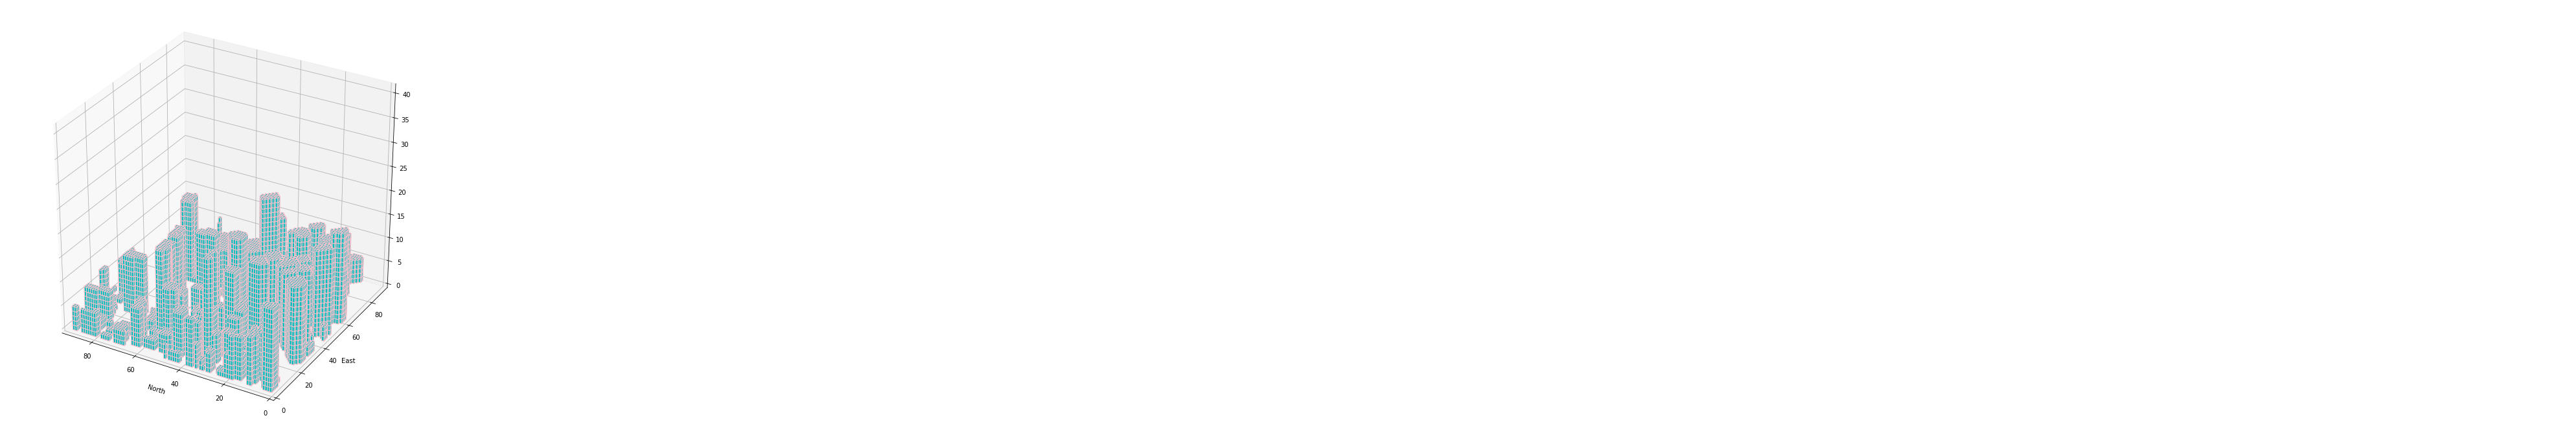

In [28]:
fig=plt.figure()
ax=fig.gca(projection='3d')
ax.voxels(voxmap, edgecolor='pink', facecolors='c')

ax.set_xlim(voxmap.shape[0], 0)
ax.set_ylim(0, voxmap.shape[1])
ax.set_zlim(0, voxmap.shape[2]+20)
plt.xlabel('North')
plt.ylabel('East')
#plt.zlabel('Down')
plt.show()

In [29]:
import sys
!{sys.executable} -m pip install -I drone

    100% |████████████████████████████████| 829kB 67kB/s ta 0:00:01
  Running setup.py bdist_wheel for drone ... done
  Stored in directory: /Users/88michael/Library/Caches/pip/wheels/18/ce/e0/61fe128b63ea7143670d94b9b6e9d2c48eb8653ba576446e1d
  Running setup.py bdist_wheel for future ... done
  Stored in directory: /Users/88michael/Library/Caches/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built drone future
udacidrone 0.3.5 has requirement future==0.16.0, but you'll have future 0.17.1 which is incompatible.


In [30]:
import sys
!{sys.executable} -m pip install -I udacidrone

  Could not find a version that satisfies the requirement udacidrone (from versions: )
No matching distribution found for udacidrone


#### Create Polygons

Your tasks will be:

1. Create polygons.
2. Sample random 3D points.
3. Remove points contained by an obstacle polygon.

Recall, a point $(x, y, z)$ collides with a polygon if the $(x, y)$ coordinates are contained by the polygon and the $z$ coordinate (height) is less than the height of the polygon.

In [13]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Polygon, Point
%matplotlib inline 
from sampling import extract_polygons

In [14]:
plt.rcParams['figure.figsize'] = 12, 12
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [15]:
print(data.shape)
print(np.max(data[:, 4]))

(3845, 6)
5.0


In [16]:
def extract_polygons(data):
    polygons=[]
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt=data[i, :]
        obstacle=[north-d_north, north+d_north, east-d_east, east+d_east]
        corners=[(obstacle[0], obstacle[2]), (obstacle[0], obstacle[3]), (obstacle[1], obstacle[3]), (obstacle[1], obstacle[2])]
        height=alt+d_alt
        p=Polygon(corners)
        polygons.append((p, height))
    
    return polygons    

In [17]:
polygons=extract_polygons(data)
print(len(polygons))

3845


#### Sampling 3D Points

Now that we have the extracted the polygons, we need to sample random 3D points. Currently we don't know suitable ranges for x, y, and z. Let's figure out the max and min values for each dimension.

In [18]:
xmin=np.min(data[:, 0]-data[:, 3])
xmax=np.max(data[:, 0]+data[:, 3])
ymin=np.min(data[:, 1]-data[:, 4])
ymax=np.max(data[:, 1]+data[:, 4])
zmin=0
zmax=10
print("X")
print("min={0}, max={1}\n".format(xmin, xmax))
print("Y")
print("min={0}, max={1}\n".format(ymin, ymax))
print("Z")
print("min={0}, max={1}".format(zmin, zmax))

X
min=-315.2389, max=604.7611

Y
min=-444.2315, max=475.7685

Z
min=0, max=10


In [19]:
num_samples=100
xvals=np.random.uniform(xmin, xmax, num_samples)
yvals=np.random.uniform(ymin, ymax, num_samples)
zvals=np.random.uniform(zmin, zmax, num_samples)
#samples=list(zip(xvals, yvals, zvals))
samples=np.array(list(zip(xvals, yvals, zvals)))
samples[:10]

array([[ 127.81899169,  145.09005083,    8.23927463],
       [-133.95158435, -195.67741957,    4.55221551],
       [  56.63796964,  368.47801403,    3.20062778],
       [-134.33665238,  -66.91231379,    5.28326449],
       [ -50.79593178,  259.19390328,    6.84235302],
       [ -46.77980272,  -35.51077887,    2.24523782],
       [-225.31454261, -260.85632837,    1.72391943],
       [ 287.48148578,  103.84848797,    6.57546376],
       [ 407.91816759, -277.96457864,    1.86306719],
       [ 174.89713802,  462.32254853,    2.9700458 ]])

#### Removing Points Colliding With Obstacles

Prior to remove a point we must determine whether it collides with any obstacle. Complete the `collides` function below. It should return `True` if the point collides with *any* obstacle and `False` if no collision is detected.

In [20]:
def collides(polygons, point):
    # TODO: Determine whether the point collides
    # with any obstacles.  
    for (p, height) in polygons:
        if p.contains(Point(point)) and height>=point[2]:
            return True
    return False

In [21]:
t0=time.time()
to_keep=[]
for point in samples:
    if not collides(polygons, point):
        to_keep.append(point)
time_taken=time.time()-t0
print("Time taken {0} seconds...".format(time_taken))

Time taken 8.087582111358643 seconds...


In [22]:
print(len(to_keep))

62


In [23]:
from enum import Enum
from queue import Queue, PriorityQueue

In [24]:
class Action(Enum):
    """
    An action is represented by a 3 element tuple.
    
    The first 2 values are the delta of the action relative
    to the current grid position. The third and final value
    is the cost of performing the action.
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        
    @property   
    def cost(self):
        return self.value[2]
    
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and current node.
    """
    valid = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # check if the node is off the grid or
    # it's an obstacle
    
    if x - 1 < 0 or grid[x-1, y] == 1:
        valid.remove(Action.UP)
    if x + 1 > n or grid[x+1, y] == 1:
        valid.remove(Action.DOWN)
    if y - 1 < 0 or grid[x, y-1] == 1:
        valid.remove(Action.LEFT)
    if y + 1 > m or grid[x, y+1] == 1:
        valid.remove(Action.RIGHT)
        
    return valid

def visualize_path(grid, path, start):
    """
    Given a grid, path and start position
    return visual of the path to the goal.
    
    'S' -> start 
    'G' -> goal
    'O' -> obstacle
    ' ' -> empty
    """
    sgrid = np.zeros(np.shape(grid), dtype=np.str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    
    for a in path:
        da = a.value
        sgrid[pos[0], pos[1]] = str(a)
        pos = (pos[0]+da[0], pos[1]+da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'
    return sgrid

In [25]:
def create_grid(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    based on given obstacle data, drone altitude and safety distance
    arguments.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil(north_max - north_min))
    east_size = int(np.ceil(east_max - east_min))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])

    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(np.clip(north - d_north - safety_distance - north_min, 0, north_size-1)),
                int(np.clip(north + d_north + safety_distance - north_min, 0, north_size-1)),
                int(np.clip(east - d_east - safety_distance - east_min, 0, east_size-1)),
                int(np.clip(east + d_east + safety_distance - east_min, 0, east_size-1)),
            ]
            grid[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1

    return grid

In [26]:
#from grid import create_grid
grid = create_grid(data, zmax, 1)

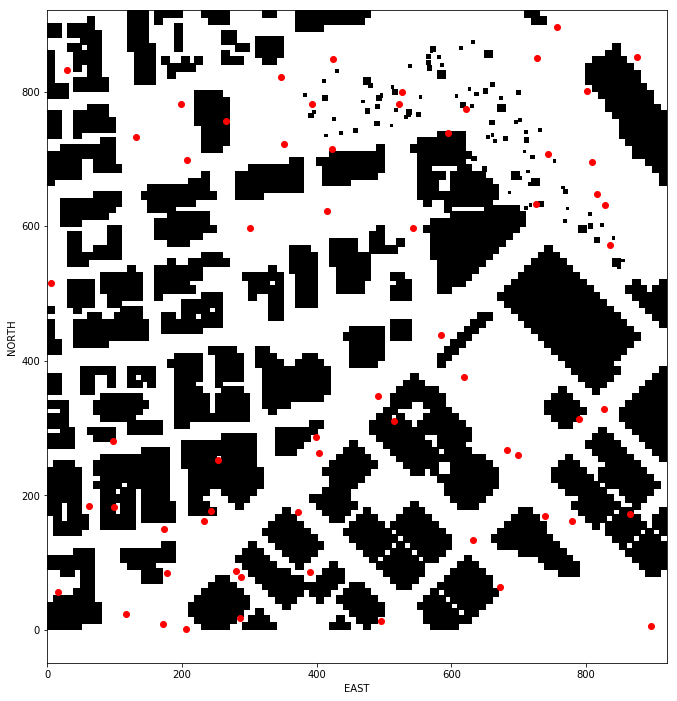

In [27]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw points
all_pts = np.array(to_keep)
north_vals = all_pts[:,0]
east_vals = all_pts[:,1]
plt.scatter(east_vals - emin, north_vals - nmin, c='red')

plt.ylabel('NORTH')
plt.xlabel('EAST')

plt.show()